In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

In [24]:
# 1. Dataset Setup
# =====================
base_dir = "D:\Basroil\cataract_project\dataset"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

# Data augmentation (overfitting)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)


Found 1531 images belonging to 2 classes.


Found 317 images belonging to 2 classes.
Found 264 images belonging to 2 classes.


<>:3: SyntaxWarning: invalid escape sequence '\B'
<>:3: SyntaxWarning: invalid escape sequence '\B'
C:\Users\mucha\AppData\Local\Temp\ipykernel_29300\402244572.py:3: SyntaxWarning: invalid escape sequence '\B'
  base_dir = "D:\Basroil\cataract_project\dataset"


In [25]:
# 2. Transfer Learning Model (MobileNetV2)
# =====================
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze dulu

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
# 3. Callbacks (Early Stopping + LR Scheduler)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)


In [27]:
# 4. Training
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    callbacks=[early_stop, reduce_lr]
)

C:\Users\mucha\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5790 - loss: 1.0077 - val_accuracy: 0.9527 - val_loss: 0.4860 - learning_rate: 1.0000e-04
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 835ms/step - accuracy: 0.8159 - loss: 0.6204 - val_accuracy: 0.9621 - val_loss: 0.3966 - learning_rate: 1.0000e-04
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 833ms/step - accuracy: 0.8757 - loss: 0.5119 - val_accuracy: 0.9621 - val_loss: 0.3765 - learning_rate: 1.0000e-04
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 835ms/step - accuracy: 0.8975 - loss: 0.4739 - val_accuracy: 0.9590 - val_loss: 0.3664 - learning_rate: 1.0000e-04
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 827ms/step - accuracy: 0.8940 - loss: 0.5088 - val_accuracy: 0.9464 - val_loss: 0.3731 - learning_rate: 1.0000e-04
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 837ms/step - accuracy: 0.9004 - loss: 0.4396 - val_accuracy: 0.9590 - val_loss: 0.3585 - learning_rate: 1.0000e-04
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 834ms/step - accura

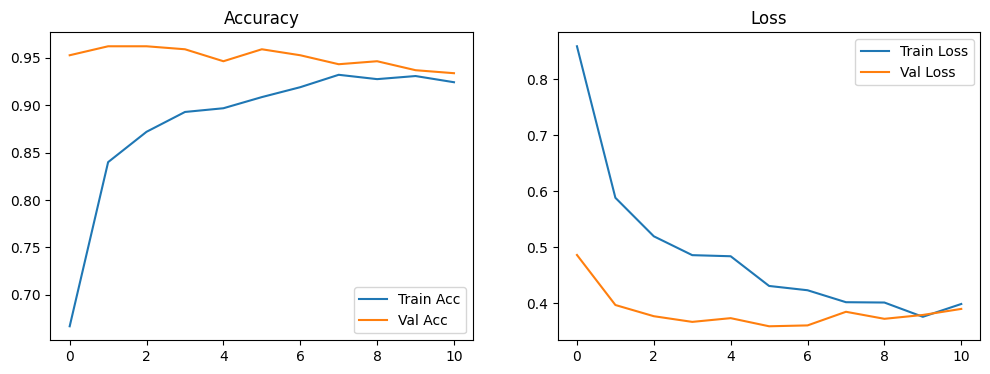

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6611 - loss: 0.9131
Test Accuracy: 0.79


In [28]:
# 5. Evaluasi Plot akurasi & loss
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

# Evaluasi test set
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 


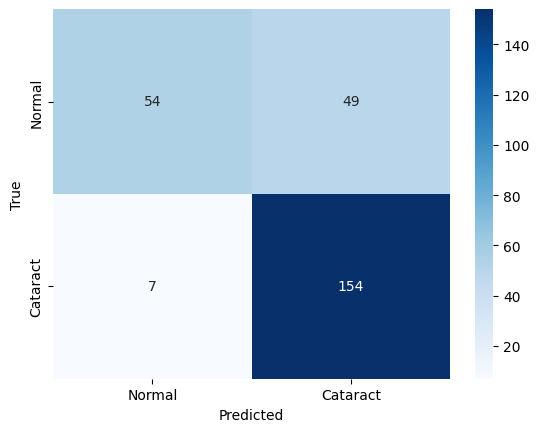

              precision    recall  f1-score   support

      Normal       0.89      0.52      0.66       103
    Cataract       0.76      0.96      0.85       161

    accuracy                           0.79       264
   macro avg       0.82      0.74      0.75       264
weighted avg       0.81      0.79      0.77       264



In [29]:
# 6. Confusion Matrix & Report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype("int32")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal","Cataract"], 
            yticklabels=["Normal","Cataract"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=["Normal","Cataract"]))


In [31]:
# 7. Save Model
# =====================
model.save("cataract_mobilenetv2.h5")